## 🔗 Workflow Overview

This TIMM-based image classification pipeline is organized into 2 modular notebooks:

1. **`TIMM_Tutorial.ipynb`**  
   Sets up the environment and trains a baseline model using a simple dataset. This is a good entry point which you can adapt to your own dataset and select a model by modifying the script accordingly.

2. **`TIMM_CustomedTrain.ipynb`**  
   Demonstrates how TIMM models can be applied to a custom image classification dataset. You can compare with TIMM_Tutorial.ipynb to verify what needs to be adjusted when fitting your own dataset and model.

➡️ Each notebook is self-contained but follows a logical order. You can run them independently after setting the correct paths and prerequisites.

# Notebook: TIMM_Tutorial

This notebook uses the subset of **imagenette2-320** dataset, located at `../dataset/imagenette2-320`.

**Objective:** It introduces TIMM and demonstrates the workflow of training using a selected architecture.

**Dataset Background**: The dataset consists of labeled images of 10 distinct ImageNet categories (e.g. tench, church, garbage truck, parachute). All images are resized so the shortest side is 320 pixels, preserving the original aspect ratio. The images are relatively easy to classify, making this a popular toy dataset for beginners in machine learning.


🔗 [License and dataset link](https://github.com/fastai/imagenette)

---

# Install
We have TIMM installed for you when you see this page

# Start trying
Ensure you have selected the right kernel (on the top right corner of jupyter lab interface), the one you have just named <br>
now we change the directory to the installed location

In [1]:
%cd ./pytorch-image-models

/home/test/carasmloo/classification/TIMM/pytorch-image-models


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Start import

In [2]:
import timm
import torch
# create a mode with timm.create_model, you can choose any
model = timm.create_model('resnet34')
# generate dummy input image, the shape is batch size, channel (RGB), height, width respectively
x = torch.randn(1, 3, 224, 224)
# function model input the batch of images and return output
y = model(x)
# resnet34 return 1000 class raw output logits
print(y.shape)
# use softmax to convert it to probability
probs = torch.nn.functional.softmax(y, dim=1)
print(probs.sum())

torch.Size([1, 1000])
tensor(1.0000, grad_fn=<SumBackward0>)


In [3]:
# create a mode with timm.create_model with pretrained weights
pretrained_resnet_34 = timm.create_model('resnet34', pretrained=True)

In [4]:
# check available models, there are so many
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]

(1599,
 ['aimv2_1b_patch14_224.apple_pt',
  'aimv2_1b_patch14_336.apple_pt',
  'aimv2_1b_patch14_448.apple_pt',
  'aimv2_3b_patch14_224.apple_pt',
  'aimv2_3b_patch14_336.apple_pt'])

In [5]:
# check available models that named with 'convnext'
all_densenet_models = timm.list_models('*convnext*')
all_densenet_models

['convnext_atto',
 'convnext_atto_ols',
 'convnext_atto_rms',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnext_zepto_rms',
 'convnext_zepto_rms_ols',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny',
 'test_convnext',
 'test_convnext2',
 'test_convnext3']

# Prepare dataset
We use a subset of Imagenette dataset as demo <br>
The dataset should be in below format

If you have your dataset labeled with labelme, you can use the below script to convert it to above specified format <br>
You can skip if you proceed with the given Imagenette dataset 

In [ ]:
import os
import json
import shutil
import random
from collections import defaultdict

# Paths 
# suppose we have a dataset dnf labeled by labelme, located in ..dataset/
src_dir = os.path.abspath("../dataset/mydataset")
# to create a copy, we give the folder a name
output_dir = os.path.abspath("../dataset/mydataset_split")
# train & validation split
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Organize images by class
class_to_images = defaultdict(list)

# Read all jsons and group images by class
for fname in os.listdir(src_dir):
    if fname.endswith(".json"):
        json_path = os.path.join(src_dir, fname)
        with open(json_path, 'r') as f:
            data = json.load(f)

        # 🔧 Extract class name from flags
        flags = data.get("flags", {})
        class_name = None
        for k, v in flags.items():
            if v is True:
                class_name = k
                break

        if not class_name:
            print(f"⚠️ Skipping unlabeled file: {fname}")
            continue

        # 🔍 Get image file from JSON
        image_name = data.get("imagePath")
        if not image_name:
            print(f"⚠️ No imagePath in {fname}")
            continue

        img_path = os.path.join(src_dir, image_name)
        if os.path.exists(img_path):
            class_to_images[class_name].append((img_path, json_path))
        else:
            print(f"⚠️ Image file not found: {img_path}")
            
# Split and copy
for class_name, items in class_to_images.items():
    random.shuffle(items)
    # train val split of 0.8
    n_train = int(0.8 * len(items))

    train_items = items[:n_train]
    val_items = items[n_train:]

    for subset_name, subset_items, subset_dir in [
        ("train", train_items, train_dir),
        ("val", val_items, val_dir)
    ]:
        class_out = os.path.join(subset_dir, class_name)
        os.makedirs(class_out, exist_ok=True)

        for img_path, _ in subset_items:
            shutil.copy(img_path, class_out)

        print(f"✅ {subset_name}/{class_name}: {len(subset_items)} files")

print("\n🎉 Done. Split complete.")


# Training
After the dataset is prepared, we can now train our model  <br>
The simpliest way is just to fill in the blanks <br>
%run train.py "your dataset location" --model "a model name" --num-classes "number of object classes" --input-size 3 "post resized height" "post resized width" --batch-size "batch size(may set higher if memory allowed)" <br> 
you may add --pretrained to initialize training with pretrained model (in this demo, as the objects are covered in pretrained model, using pretrain would make accuracy near 100%, which is not realistic in practice)<br> 
you may add --aa original or --aa v0 to activate auto augmentation  <br> 
set --epochs and --lr-base if you want custom number of epochs and learning rate <br> 
the below lines are examples

%run ./train.py ../dataset/imagenette2-320 --model resnet34 --num-classes 10 --batch-size 32 --aa original --epochs 30

In [6]:
%run ./train.py ../dataset/imagenette2-320 --model resnet34 --num-classes 10 --batch-size 32 --aa original --epochs 30

Training with a single process on 1 device (cuda).
Model resnet34 created, param count:21289802
Data processing configuration for current model + dataset:
	input_size: (3, 224, 224)
	interpolation: bicubic
	mean: (0.485, 0.456, 0.406)
	std: (0.229, 0.224, 0.225)
	crop_pct: 0.95
	crop_mode: center
Learning rate (0.0125) calculated from base learning rate (0.1) and effective global batch size (32) with linear scaling.
Created SGD (sgd) optimizer: lr: 0.0125, momentum: 0.9, dampening: 0, weight_decay: 2e-05, nesterov: True, maximize: False, foreach: None, differentiable: False, fused: None
AMP not enabled. Training in torch.float32.
Scheduled epochs: 30 (epochs + cooldown_epochs). Warmup within epochs when warmup_prefix=False. LR stepped per epoch.
Train: 0 [   0/295 (  0%)]  Loss: 2.35 (2.35)  Time: 0.861s,   37.17/s  (0.861s,   37.17/s)  LR: 1.000e-05  Data: 0.252 (0.252)
Train: 0 [  50/295 ( 17%)]  Loss: 2.30 (2.32)  Time: 0.017s, 1859.18/s  (0.034s,  935.88/s)  LR: 1.000e-05  Data: 0.

--result
[
    {
        "epoch": 19,
        "train": {
            "loss": 1.3727288116843013
        },
        "validation": {
            "loss": 0.76666117882273,
            "top1": 76.73885351873507,
            "top5": 97.5031847133758
        }
    },
    {
        "epoch": 21,
        "train": {
            "loss": 1.3392384173506398
        },
        "validation": {
            "loss": 0.6912502802329459,
            "top1": 78.54777070646833,
            "top5": 98.29299363057325
        }
    },
    {
        "epoch": 22,
        "train": {
            "loss": 1.309366529876903
        },
        "validation": {
            "loss": 0.7035911316021233,
            "top1": 78.85350319054476,
            "top5": 98.11464968152866
        }
    },
    {
        "epoch": 23,
        "train": {
            "loss": 1.290319324549982
        },
        "validation": {
            "loss": 0.6938430173230019,
            "top1": 79.71974522876133,
            "top5": 98.1656050955

In [7]:
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Read the training log
About every 50 iterations in training, the log prints current training status incluing Loss and learning rate(LR). <br>
About every 50 iterations in validation(test), the log prints current validation status incluing Loss and accuracy(Acc) in top1 and top5. <br>
Current checkpoints list out the checkpoints with the best top1 accuracy <br>

In ideal scenario, training loss and validation loss decrease gradually throughout the training, where training loss usually goes faster. <br> 
When it comes to the end of training, training loss would still decreases slightly, while validation loss stops decreasing, and the accuracy should be satisfactory. <br>
 <br>
If both training and validation loss decrease slowly, you may increase learning rate (eg double it, given default 0.1) <br>
If both training and validation loss fluctuate violently, you may decrease learning rate (eg half it) <br>
If both training and validation loss are still decreasing at the end of training, you may increase number of epoch <br>
If training loss decreases while validation loss stagnates or bounces back before getting satisfactory accuracy, you should add more samples or implement stronger augmentation, and ensure the two datasets are alike <br>
If both training and validation loss stagnates, and the accuracy is not satisfactory, you should consider choosing a more advanced or larger model <br>
 <br>
there are a lot of parameters available for your custom settings <br>
you may go to <br>
./train.py <br>
for details <br>

# Augmentations

Once you run the %run ./train.py script above, it will save a batch of augmented images in saved_images/ <br>
 <br>
If you want to use some augmentation transform that only available in the Albumentations package <br>
you can go to timm/data/transforms_factory.py <br>
revise the line <br>
a_tfl = []<br>
to something like <br>
a_tfl = [A.Affine(p=0.5),A.RandomBrightnessContrast(p=0.5),A.HueSaturationValue(p=0.5)]<br>
if you dont want the Albumentations augmentations, keep a_tfl = [] <br>
You need to restart kernal after any revision on the .py <br>
Check https://github.com/albumentations-team/albumentations for details of Albumentations

# Inference
Here we inference on a single image <br>
check the log of training <br>
here we have <br>

In [8]:
import os
from glob import glob

def get_best_checkpoint(base_dir="./output/train"):
    subdirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    subdirs.sort(key=os.path.getmtime, reverse=True)  # Sort by Time
    for d in subdirs:
        ckpt_path = os.path.join(d, "model_best.pth.tar")
        if os.path.exists(ckpt_path):
            return ckpt_path
    return None

best_ckpt = get_best_checkpoint()
print(f"Using checkpoint: {best_ckpt}")

Using checkpoint: ./output/train/20250707-115329-resnet34-224/model_best.pth.tar


Predicted class: Tench with probability: 0.8517


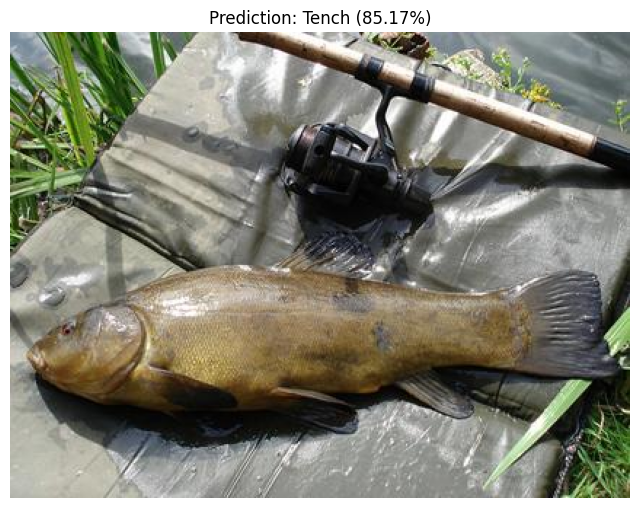

Tench: 85.17%
English Springer Spaniel: 2.87%
Cassette Player: 0.77%
Chain Saw: 5.51%
Church: 0.20%
French Horn: 1.35%
Garbage Truck: 1.34%
Gas Pump: 0.34%
Golf Ball: 1.36%
Parachute: 1.11%


In [9]:
# inference on torch
import torch
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from PIL import Image
import matplotlib.pyplot as plt

# === Model configuration ===
model_name = 'resnet34' 
num_classes = 10
# the model is saved in output/train/afolderwithdatetime,modelname,shape/
# we use the model_best.pth
checkpoint_path = best_ckpt

# === Create model architecture ===
model = timm.create_model(model_name, num_classes=num_classes)

# === Load checkpoint safely (set weights_only=False for PyTorch >= 2.6) ===
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Extract state_dict (either from wrapped checkpoint or direct)
state_dict = checkpoint.get('state_dict', checkpoint)
model.load_state_dict(state_dict)
model.eval()

# === Image preprocessing ===
config = resolve_data_config({}, model=model)
config['input_size'] = (3, 224, 224)  # refer to the config of you training, not neccessarily the our demo case
config['crop_pct'] = 0.95  # Match training crop ratio
transform = create_transform(**{**config, 'is_training': False})

# === Load and transform a single image ===
# give a sample image
img_path = '../dataset/imagenette2-320/val/n01440764/ILSVRC2012_val_00009111.JPEG'
img = Image.open(img_path).convert('RGB')
tensor = transform(img).unsqueeze(0)  # Add batch dimension

# === Inference ===
with torch.no_grad():
    output = model(tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# === Interpret the prediction ===
class_names = [
    'Tench', 'English Springer Spaniel', 'Cassette Player', 'Chain Saw', 'Church',
    'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute'
]

max_prob, predicted_class = torch.max(probabilities, dim=0)
print(f"Predicted class: {class_names[predicted_class]} with probability: {max_prob.item():.4f}")

# === Display image and prediction ===
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class]} ({max_prob.item():.2%})")
plt.axis('off')
plt.show()

# === Print all class probabilities ===
for i, prob in enumerate(probabilities):
    print(f"{class_names[i]}: {prob.item():.2%}")


Here we inference on the whole val dataset, which will return a csv storing prediction of each image<br>
First create this dir <br>

In [10]:
%cd output
!mkdir inference
%cd ..

/home/test/carasml/classification/TIMM/pytorch-image-models/output
mkdir: 不能建立目錄 ‘inference’: File exists
/home/test/carasml/classification/TIMM/pytorch-image-models


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


fill in the blanks <br>
%run inference.py "your dataset location" --model "model name" --num-classes "number of object classes" --img-size "height&width" --batch-size "batch size" --checkpoint "check point location stored in ./output/train/" --results-dir "where you want to save results" --include-index

In [10]:
%run inference.py ../dataset/imagenette2-320\
    --model resnet34 \
    --num-classes 10 \
    --img-size 224 \
    --checkpoint {best_ckpt} \
    --batch-size 32 \
    --results-dir ./output/inference \
    --include-index

Running inference in float32. AMP not enabled.
Running inference in float32. AMP not enabled.
Loaded state_dict from checkpoint './output/train/20250707-115329-resnet34-224/model_best.pth.tar'
Loaded state_dict from checkpoint './output/train/20250707-115329-resnet34-224/model_best.pth.tar'
Model resnet34 created, param count: 21289802
Model resnet34 created, param count: 21289802
ERROR: Cannot deduce ImageNet subset from model, no labelling will be performed.
ERROR: Cannot deduce ImageNet subset from model, no labelling will be performed.
Predict: [0/123] Time 0.167 (0.167)
Predict: [0/123] Time 0.167 (0.167)
Predict: [10/123] Time 0.006 (0.044)
Predict: [10/123] Time 0.006 (0.044)
Predict: [20/123] Time 0.006 (0.037)
Predict: [20/123] Time 0.006 (0.037)
Predict: [30/123] Time 0.005 (0.035)
Predict: [30/123] Time 0.005 (0.035)
Predict: [40/123] Time 0.005 (0.033)
Predict: [40/123] Time 0.005 (0.033)
Predict: [50/123] Time 0.005 (0.033)
Predict: [50/123] Time 0.005 (0.033)
Predict: [60

--result
{
    "ILSVRC2012_val_00009111.JPEG":{
        "index":0,
        "prob":0.851546526
    },
    "ILSVRC2012_val_00009191.JPEG":{
        "index":0,
        "prob":0.824230969
    },
    "ILSVRC2012_val_00017472.JPEG":{
        "index":0,
        "prob":0.9866753221
    },
    "ILSVRC2012_val_00017700.JPEG":{
        "index":0,
        "prob":0.9965332747
    },
    "ILSVRC2012_val_00021740.JPEG":{
        "index":0,
        "prob":0.5835481882
    },
    "ILSVRC2012_val_00029930.JPEG":{
        "index":0,
        "prob":0.9933879375
    },
    "ILSVRC2012_val_00030740.JPEG":{
        "index":0,
        "prob":0.8819329143
    },
    "ILSVRC2012_val_00037861.JPEG":{
        "index":0,
        "prob":0.8446737528
    },
    "ILSVRC2012_val_00045880.JPEG":{
        "index":0,
        "prob":0.9265499711
    },
    "ILSVRC2012_val_00046252.JPEG":{
        "index":0,
        "prob":0.9615900517
    },
    "n01440764_141.JPEG":{
        "index":1,
        "prob":0.3939372301
    },


In [11]:
#after validation or inference, clear cache
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()

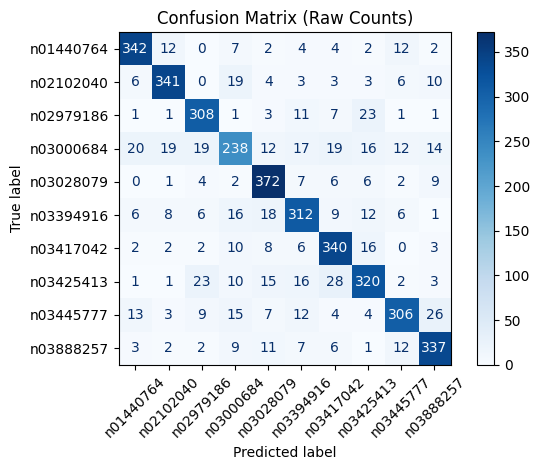

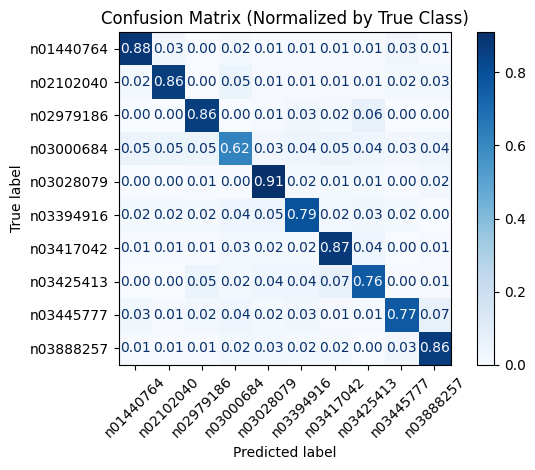

Per-class accuracy: [0.88372093 0.86329114 0.8627451  0.61658031 0.90953545 0.79187817
 0.87403599 0.76372315 0.76691729 0.86410256]
Mean class accuracy: 0.8197


In [12]:
# plot confusion matrix
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Path to the validation dataset and prediction CSV
val_dir = '../dataset/imagenette2-320/val'
csv_path = './output/inference/resnet34-224.csv'

# Load predictions
df_pred = pd.read_csv(csv_path)

# Step 1: Get mapping of filename to ground truth label from val directory
true_labels = {}
class_names = sorted(os.listdir(val_dir))  # list of class names (sorted for consistent indexing)
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    for fname in os.listdir(class_path):
        true_labels[fname] = class_to_idx[class_name]

# Step 2: Map true labels to the predictions
df_pred['true'] = df_pred['filename'].map(true_labels)

# Drop rows where mapping failed
df_pred = df_pred.dropna(subset=['true'])

# Convert to int
df_pred['true'] = df_pred['true'].astype(int)
df_pred['index'] = df_pred['index'].astype(int)

# Step 3: Raw confusion matrix
y_true = df_pred['true']
y_pred = df_pred['index']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (Raw Counts)")
plt.tight_layout()
plt.show()

# Step 4: Normalized confusion matrix (percentage)
cm_percent = confusion_matrix(y_true, y_pred, normalize='true')
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)
disp_percent.plot(xticks_rotation=45, cmap='Blues', values_format=".2f") 
plt.title("Confusion Matrix (Normalized by True Class)")
plt.tight_layout()
plt.show()

# Step 5: Compute per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Step 6: Compute mean (class-averaged) accuracy
mean_class_accuracy = per_class_acc.mean()

print("Per-class accuracy:", per_class_acc)
print(f"Mean class accuracy: {mean_class_accuracy:.4f}")

# The counts lie inside the top left to bottom right diagonal are the correct predictions
# The others are wrong predictions, where the x-axis is the predicted label and the y-axis is true label
# eg, the top right corner are the samples that are actually n01440764(tench) but misclassified as n03888257(Parachute)

# Export to onnx
export to onnx can be more convenient to inference on other devices

fill in the blanks <br>
%run onnx_export.py "name your onnx" --model "model name" --num-classes "number of object classes" --img-size "height&width" --checkpoint "check point location stored in ./output/train/"

In [13]:
%run onnx_export.py  resnet34_imagenet.onnx \
    --model resnet34 \
    --num-classes 10 \
    --img-size 224 \
    --checkpoint {best_ckpt}

Loaded state_dict from checkpoint './output/train/20250707-115329-resnet34-224/model_best.pth.tar'
Loaded state_dict from checkpoint './output/train/20250707-115329-resnet34-224/model_best.pth.tar'


==> Creating PyTorch resnet34 model


Predicted Class Index: 0
Probabilities: [[0.773147   0.08164781 0.00352243 0.05473495 0.00289678 0.03047857
  0.00843407 0.0028523  0.03128411 0.01100197]]


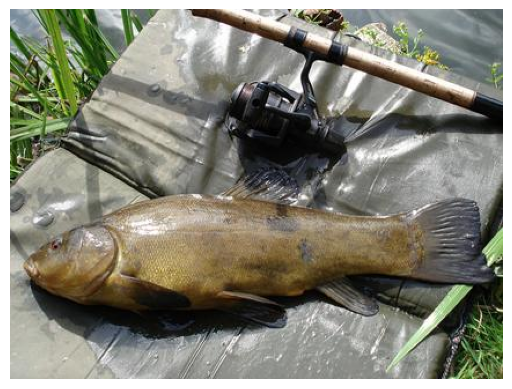

In [14]:
# inference with onnx
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt

# Load the image using OpenCV
image = cv2.imread('../dataset/imagenette2-320/val/n01440764/ILSVRC2012_val_00009111.JPEG')  # Load image in BGR format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# check the log of training for correct info
# Resize the image to your model input size
resized_image = cv2.resize(image, (224, 224))

# Normalize the image
mean = [0.485, 0.456, 0.406]  # Mean for normalization
std = [0.229, 0.224, 0.225]   # Standard deviation for normalization
normalized_image = (resized_image / 255.0  - mean) / std

# Convert the image to a format suitable for ONNX inference
input_tensor = normalized_image.transpose(2, 0, 1)  # Change shape from (H, W, C) to (C, H, W)
input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension (1, C, H, W)
input_tensor = input_tensor.astype(np.float32)       # Ensure the data type is float32

# Load the ONNX model, REMEMBER TO REVISE THE NAME
session = onnxruntime.InferenceSession("resnet34_imagenet.onnx", providers=["CUDAExecutionProvider"])

# Get the input name for the model
input_name = session.get_inputs()[0].name

# Run inference
outputs = session.run(None, {input_name: input_tensor})

# Get the output (logits)
logits = outputs[0]

# Apply softmax to convert logits to probabilities
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

# Get the predicted class index
predicted_class_index = np.argmax(probabilities)

# Print the predicted class index and probabilities
print(f"Predicted Class Index: {predicted_class_index}")
print(f"Probabilities: {probabilities}")
plt.imshow(image)
plt.axis("off")  # Hide axes for better visualization
plt.show()